# **9-3. VGGNet(Visual Geometry Group)**
-----
### **다시 정리하는 VGGNet**
여러 버전이 있으며, LeNet, AlexNet과 구성 요소는 동일.(합성곱층, 풀링층, FC)    
하지만, 신경망 층 수가 더 많음.   

모든 층의 hyper parameter가 동일한게 특징, 신경망을 이해하기 쉬움.   
>- 3 x 3 filter
- stride = 1
- padding = 1
- 2 x 2 pool, stride = 2

더 세밀한 특징을 추출하기 위해 LeNet, AlexNet보다 필터 크기를 3 x 3으로 줄였음.    
- 수용 영역(Receptive Field, 필터가 위치한 이미지 상의 범위)크기가 같을 때, 큰 커널 1개보다 작은 커널 여러개가 성능이 더 좋음.    
- 커널 크기 3 x 3 합성곱층 2개 = 5 x 5 수용 영역 가진 합성곱층

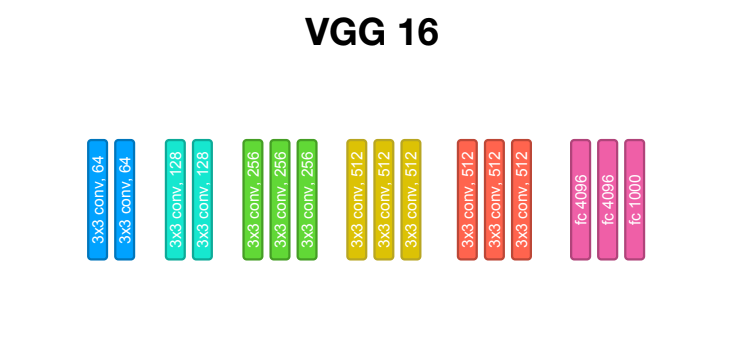

Convolution 층 지나면서 **깊이는 증가**하고, Pooling 층 지나면서 **이미지 사이즈는 작아짐**.    
👉 이미지의 공간적 정보를 줄이면서도 특징을 추출하고, 더 깊은 네트워크 구조를 통해 복잡한 패턴 학습 가능!    

- Dropout 비율 0.5, 마지막 층 제외 두 개의 FC 층에 적용됨.
- Minibatch Gradient Descent, momentum: 0.9
- Learning rate = 0.01, 검증 data accuracy 정체시 1/10배 감소
- 가중치 감쇠율 = 5 × 10^(-4) 적용한 L2 규제화
<br>

🔎 **L2 Regularization**    
$$Regularized\,Loss = Loss + \frac{λ}{2n} \sum_{i=1}^{n} w_i^2$$
기존의 Cost Function에 가중치의 제곱을 포함하여 더함으로써, 가중치가 너무 크지 않은 방향으로 학습되도록 함.   
👉 적당히 큰 값을 더해줘서 cost function이 무조건 가중치를 줄이는 방향으로 학습하게 함.

## **torchvision.models.vgg**
- vgg11부터 vgg19까지 만들 수 있도록 되어 있음.
- 3 x 224 x 224 입력을 기준으로 만들도록 되어 있음.
- input size가 다른 경우 VGG를 적용하려면 어떻게 해야 할까? 알아보러 갑시다

In [21]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

In [2]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


model_urls = { # ImageNet Challange를 기반으로 미리 Pre-training 시켜놓은 모델들
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}

In [3]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()

        self.features = features # Convolution
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7)) # 입력에 관계없이 출력을 고정하도록 설계
        self.classifier = nn.Sequential( # FC Layer
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x) # Convolution
        x = self.avgpool(x) # Pooling
        x = x.view(x.size(0), -1)
        x = self.classifier(x) #FC

    def _initialize_weights(self):
        for m in self.modules(): # features의 값을 m에게 하나씩 리턴
            if isinstance(m, nn.Conv2d): # m이 nn.Conv2d일 때
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') #input tensor가 He초기값으로 U(-bound,bound)의 균일분포를 갖는다.
                if m.bias is not None: # VGG에서는 bias 값이 0이다
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [4]:
# 'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

def make_layers(cfg, batch_norm=False):
    layers=[]
    in_channels = 3

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size = 3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)
# [layers]
# conv2d = nn.Conv2d(3, 64, kernel_size = 3, padding=1)
# nn.ReLU(inplace=True)
# nn.MaxPool2d(kernel_size=2, stride=2)
# conv2d = nn.Conv2d(64, 128, kernel_size = 3, padding=1)
# nn.ReLU(inplace=True)
# nn.MaxPool2d(kernel_size=2, stride=2)
# ....


In [5]:
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #8 + 3 =11 == vgg11 (합성곱 층 + FC층)
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'], # 16 +3 =vgg 19
    'custom' : [64,64,64,'M',128,128,128,'M',256,256,256,'M']
}

In [6]:
conv = make_layers(cfg['custom'], batch_norm=True)
conv

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [7]:
CNN = VGG(make_layers(cfg['custom']), num_classes=10, init_weights=True)

In [8]:
CNN

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddin

## **VGG for cifar10**

In [1]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [4]:
import visdom

vis = visdom.Visdom()
vis.close(env="main")

Setting up a new session...


''

### **define loss tracker**

In [5]:
def loss_tracker(loss_plot, loss_value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=loss_value,
             win = loss_plot,
             update='append')

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [8]:
transform = transforms.Compose( #.Compose: Composes several transforms together.
    [transforms.ToTensor(), # 이미지 데이터는 [0, 255] 범위에서 [0, 1] 범위로 스케일링되고,
                            # 채널 순서가 HWC(High, Width, Channel)에서 CHW(Channel, High, Width)로 변경
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Normalize((채널 별 mean값),(std값))
                                                              #각각의 값들이 (x-mean/std)로 바뀐다.
                                                              #범위는 [-1, 1]

train_set = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=512,
                                          shuffle=True, num_workers=0)#num_workers: 데이터로더가
                                                                       #데이터를 로드하는 데 사용하는
                                                                       #스레드(thread)의 수를 결정하는 매개변수

test_set = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    img = img / 2 +0.5  #unnormalize #[0,1]range로 돌아간다. ((image * std) + mean)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))#(C,H,W)에서 (H, W, C)로 변경. (1번째가 0번째, 2번째가 1번째...)
    plt.show()

dataiter = iter(train_loader)# iter는 반복 가능한 객체에서 이터레이터를 반환하고,
images, labels = dataiter.next()#next는 이터레이터에서 값을 차례대로 꺼냅니다
vis.images(images/2 + 0.5)

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

truck   car   car   cat


### **make VGG16 using vgg.py**

In [10]:
import torchvision.models.vgg as vgg
#import vgg

In [11]:
cfg = [32,32,'M', 64,64,128,128,128,'M',256,256,256,512,512,512,'M'] #13 + 3 =vgg16

In [12]:
class VGG(nn.Module):
    def __init__ (self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [13]:
vgg16 = VGG(vgg.make_layers(cfg), 10, True).to(device)

In [14]:
a = torch.Tensor(1, 3, 32, 32).to(device)
out = vgg16(a)
print(out)

tensor([[-0.0377, -0.0019, -0.0184, -0.0221, -0.0070, -0.0735, -0.0189,  0.0612,
         -0.0393, -0.0085]], grad_fn=<AddmmBackward0>)


In [15]:
criterion = nn.CrossEntropyLoss().to(device)
#momentum: 이전 그래디언트를 고려하여 가중치 업데이트에 얼마나 많은 비중을 두는지를 조절하는 역할
#          모멘텀 파라미터가 1에 가까울수록 이전 그래디언트의 영향이 크게 반영
optimizer = optim.SGD(vgg16.parameters(), lr = 0.005, momentum = 0.9)

#learning rate를 조금씩 감소시키면서 학습시킨다.
#scheduler 5번 할 때 마다 learning rate값에 0.9를 곱해주세요
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

### **make plot**

In [16]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(), opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))

### **training**

In [18]:
print(len(train_loader))
epochs = 30 #시간이 너무 오래 걸려서 30번만 돌리겠습니다...

for epoch in range(1, epochs+1):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 30 == 0:
            loss_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(train_loader) ]))
            print('[%d, %5d] loss: %.3f' %
                  (epoch, i, running_loss / 30))
            running_loss = 0.0
            
    lr_sche.step() # epoch 다섯번 돌 때 마다 learning rate에 0.9씩 곱해져요
print('Finished Training')

98
[1,     0] loss: 0.077
[1,    30] loss: 2.299
[1,    60] loss: 2.292
[1,    90] loss: 2.250
[2,     0] loss: 0.071
[2,    30] loss: 2.344
[2,    60] loss: 2.242
[2,    90] loss: 2.155
[3,     0] loss: 0.071
[3,    30] loss: 2.081
[3,    60] loss: 2.041
[3,    90] loss: 1.991
[4,     0] loss: 0.066
[4,    30] loss: 1.918
[4,    60] loss: 1.870
[4,    90] loss: 1.824
[5,     0] loss: 0.060
[5,    30] loss: 1.762
[5,    60] loss: 1.740
[5,    90] loss: 1.696
[6,     0] loss: 0.054
[6,    30] loss: 1.664
[6,    60] loss: 1.646
[6,    90] loss: 1.633
[7,     0] loss: 0.053
[7,    30] loss: 1.582
[7,    60] loss: 1.576
[7,    90] loss: 1.544
[8,     0] loss: 0.049
[8,    30] loss: 1.519
[8,    60] loss: 1.478
[8,    90] loss: 1.449
[9,     0] loss: 0.046
[9,    30] loss: 1.410
[9,    60] loss: 1.415
[9,    90] loss: 1.389
[10,     0] loss: 0.045
[10,    30] loss: 1.339
[10,    60] loss: 1.346
[10,    90] loss: 1.342
[11,     0] loss: 0.045
[11,    30] loss: 1.281
[11,    60] loss: 1.267
[

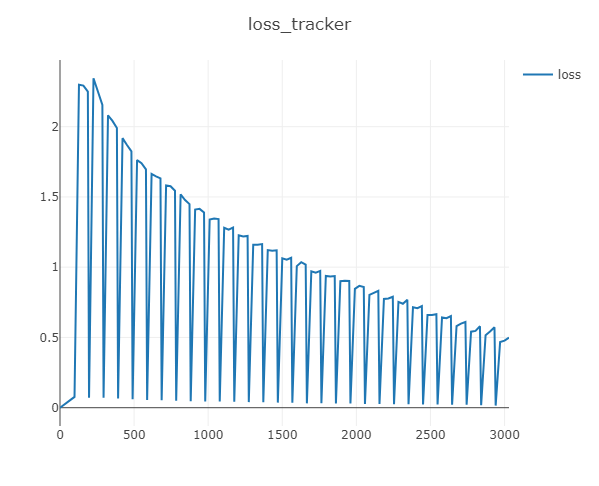

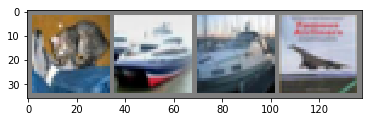

GroundTruth:    cat  ship  ship plane


In [19]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [23]:
outputs = vgg16(images.to(device))

In [24]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [28]:
correct =0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)

        _, predicted = torch.max(outputs.data, 1)

        total+= labels.size(0)

        correct += (predicted == labels).sum().item()

print("Accuracy of the network on the 10000 test images: %d %%" %(100 * correct /total))

Accuracy of the network on the 10000 test images: 67 %
